In [ ]:
# Install necessary libraries
!pip install keras-tuner --upgrade
!pip install imbalanced-learn lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Load datasets from Google Drive
train_path = "/content/drive/MyDrive/CN M Training/UNSW_NB15_training-set.csv"
test_path = "/content/drive/MyDrive/CN M Training/UNSW_NB15_testing-set.csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

Mounted at /content/drive


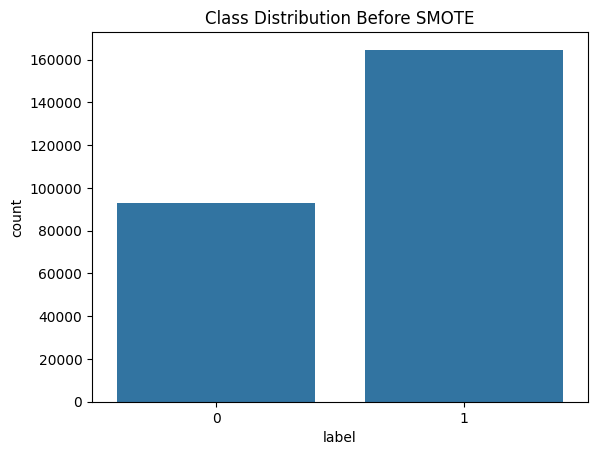

In [ ]:
# Combine train and test for consistent preprocessing
df = pd.concat([df_train, df_test])

# Drop irrelevant columns
drop_columns = ['id', 'attack_cat']  # Modify if necessary
if set(drop_columns).issubset(df.columns):
    df.drop(columns=drop_columns, inplace=True)

# Encode categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Check class distribution
sns.countplot(x=df['label'])
plt.title("Class Distribution Before SMOTE")
plt.show()

In [ ]:
# Feature selection using Random Forest
X = df.drop(columns=['label'])
y = df['label']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
important_features = feature_importance.sort_values(by="Importance", ascending=False)["Feature"].iloc[:20].values
X = df[important_features]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [ ]:
# Build improved DNN model
def build_improved_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the improved DNN model
model = build_improved_model()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=50, batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report for DNN:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8761 - loss: 0.3067 - val_accuracy: 0.9121 - val_loss: 0.1940
Epoch 2/50
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9108 - loss: 0.2002 - val_accuracy: 0.9247 - val_loss: 0.1766
Epoch 3/50
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9197 - loss: 0.1880 - val_accuracy: 0.9248 - val_loss: 0.1728
Epoch 4/50
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9209 - loss: 0.1847 - val_accuracy: 0.9231 - val_loss: 0.1743
Epoch 5/50
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9217 - loss: 0.1836 - val_accuracy: 0.9205 - val_loss: 0.1789
Epoch 6/50
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9224 - loss: 0.1829 - val_accuracy: 0.9258 - val_loss: 0.1697
Epoch 7/50
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9229 - loss: 0.1806 - val_accuracy: 0.9177 - val_loss: 0.1807
Epoch 8/50
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9224 - loss: 0

In [ ]:
# Tune LightGBM hyperparameters
params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc', 'accuracy'],
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.01,
    'max_depth': 12,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Train LightGBM model
lgb_train = lgb.Dataset(X_train_resampled, y_train_resampled)
lgb_test = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_test])

# Evaluate LightGBM
lgb_preds = (lgb_model.predict(X_test) > 0.5).astype("int32")
lgb_acc = accuracy_score(y_test, lgb_preds)
print(f"LightGBM Test Accuracy: {lgb_acc:.4f}")

# Classification report for LightGBM
print("\nClassification Report for LightGBM:")
print(classification_report(y_test, lgb_preds))

LightGBM Test Accuracy: 0.9321

Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     18613
           1       0.97      0.92      0.95     32922

    accuracy                           0.93     51535
   macro avg       0.92      0.94      0.93     51535
weighted avg       0.94      0.93      0.93     51535



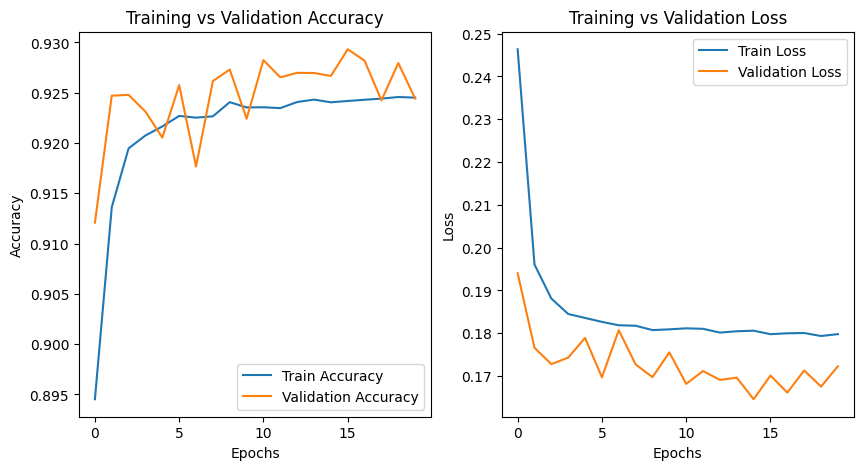

In [ ]:
# Plot Accuracy and Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()

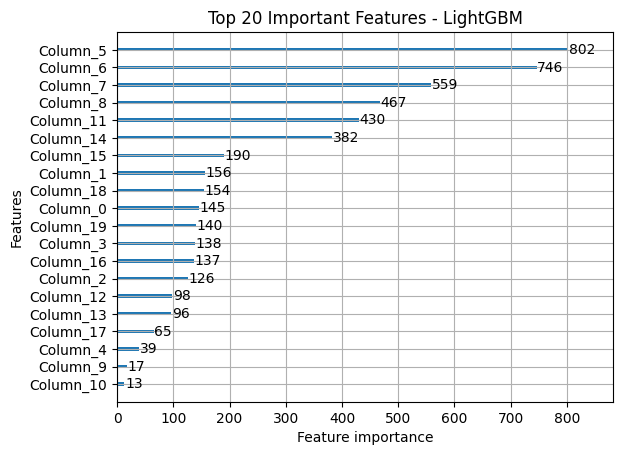

In [ ]:
lgb.plot_importance(lgb_model, max_num_features=20)
plt.title("Top 20 Important Features - LightGBM")
plt.show()

In [ ]:
# Save trained models to Google Drive
model.save("/content/drive/MyDrive/CN M Training/dnn_ids_model.h5")
lgb_model.save_model("/content/drive/MyDrive/CN M Training/lgbm_ids_model.txt")